### Filtering raw data

Author: Ruth Hanna

This notebook combines pDNA and gDNA sequencing data and applies two filters. One is to remove any sgRNAs with an outlier pDNA count. The second is to remove any sgRNAs with > 5 off-targets in Match Bin I.

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import log, isnan

First, we merge the files containing lognorms for pDNA and gDNA.

In [6]:
def calc_lognorm(df, col):
    col_sum = np.sum(df[col])
    df.loc[:,'lognorm'] = [np.log2((x*1000000/float(col_sum))+1) for x in df[col]]
    return df

In [8]:
# Read in plasmid DNA lognorms
pdna = pd.read_table('../data/raw/lognorm-BF20200608_B05_AAGB04_RDA208_G1_CP1560_M-AK47.txt')

# Take lognorm
pdna = pdna.rename(columns = {'B05_AAGB04_RDA208_G1_CP1560_M-AK47':'pDNA'})
pdna.shape

(148, 7)

In [11]:
# Read in lognorms 
lognorms = pd.read_table('../data/raw/lognorm-JD_GPP1868_Alfajaro_Wilen_CP1560.txt')
lognorms = lognorms.filter(regex='CP1560|Construct')
lognorms.shape

(148, 4)

In [12]:
# Merge pDNA lognorms with gDNA conditions
all_lognorms = pd.merge(pdna[['Construct Barcode', 'pDNA']], lognorms, on='Construct Barcode', how='inner')
all_lognorms.shape

(148, 5)

#### pDNA filter
Next, we apply a filter to remove any sgRNAs for which lognorm(pDNA) is more than 3 standard deviations from the mean. This removes 2 sgRNAs.

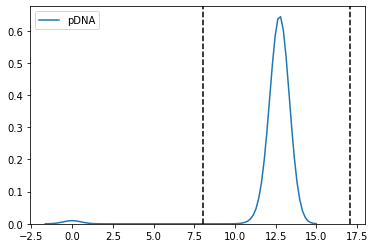

In [14]:
# Apply a filter for sgRNAs with outlier pDNA counts
fig, ax = plt.subplots()
sns.kdeplot(all_lognorms['pDNA'])
low_cutoff = all_lognorms['pDNA'].mean() - 3*all_lognorms['pDNA'].std()
high_cutoff = all_lognorms['pDNA'].mean() + 3*all_lognorms['pDNA'].std()
ax.axvline(low_cutoff, color = 'black', linestyle = 'dashed')
ax.axvline(high_cutoff, color = 'black', linestyle = 'dashed')

In [15]:
all_lognorms.loc[:, 'pDNA_filter'] = all_lognorms.loc[:, 'pDNA'].apply(lambda x: ((x < low_cutoff) or (x > high_cutoff)))
all_lognorms['pDNA_filter'].value_counts()

False    146
True       2
Name: pDNA_filter, dtype: int64

#### Off-target filter
Next, we load the original picking file, which contains a FISHR search. We calculate the total number of off-targets in Match Bin I (CFD100 match) and filter out any sgRNAs with > 5 off-targets in Match Bin I. This filter identifies 120 sgRNAs.

In [16]:
picking_stats = pd.read_table('../data/raw/sgRNA_design_60711_Chlorocebus_sabeus_1.1_SpyoCas9_CRISPRko_NCBI_20200415.txt', 
                              usecols=['sgRNA Sequence',
                                       '# Off-Target Tier I Match Bin I Matches', 
                                       '# Off-Target Tier II Match Bin I Matches',
                                       '# Off-Target Tier III Match Bin I Matches',
                                       '# Off-Target Tier IV Match Bin I Matches'])

print(picking_stats.shape)

# Filter file to remove any sgRNAs not in final library
picking_stats = picking_stats.loc[picking_stats['sgRNA Sequence'].isin(all_lognorms['Construct Barcode'].tolist())]

print(picking_stats.shape)

(5541536, 5)
(128, 5)


A small number of sgRNAs (~2000) are listed multiple times in the picking file. It looks like this is mainly in cases where they target multiple genes (i.e. multiple transcripts are annotated at the same site). In such cases, we take the maximum Match Bin I sum.

In [17]:
def get_mb_sum(row):
    if row['# Off-Target Tier I Match Bin I Matches'] == 'MAX':
        return 40000
    mb_sum = 0
    for tier in ['I','II','III','IV']:
        col = '# Off-Target Tier '+tier+' Match Bin I Matches'
        mb_sum += int(row[col])
    return mb_sum

# Calculate the Match Bin I sum
picking_stats.loc[:, 'Match Bin I sum'] = picking_stats.apply(get_mb_sum, axis=1)

# A small number of sgRNAs are listed twice (for different genes)
# We take the max Match Bin I sum to be conservative
picking_stats = picking_stats.loc[:,['sgRNA Sequence', 'Match Bin I sum']].groupby('sgRNA Sequence').agg('max')
print(picking_stats.shape)

(128, 1)


In [18]:
print(all_lognorms.shape)

# We merge the Match Bin I sum column onto our original dataframe
all_lognorms = pd.merge(all_lognorms, picking_stats, left_on='Construct Barcode', right_index=True, how='left')

# Fill in any NaNs with 0 (this is for non-targeting controls, which will not be in the picking file)
all_lognorms.loc[:, 'Match Bin I sum'] = all_lognorms.loc[:, 'Match Bin I sum'].fillna(0) 

print(all_lognorms.shape)

(148, 6)
(148, 7)


In [19]:
all_lognorms['Match Bin I sum'].value_counts()

0.0    142
1.0      6
Name: Match Bin I sum, dtype: int64

In [20]:
# Filter out sgRNAs with > 5 sites in Match Bin I
all_lognorms.loc[:, 'off_target_filter'] = all_lognorms.loc[:, 'Match Bin I sum'].apply(lambda x: x not in range(0, 6))
all_lognorms['off_target_filter'].value_counts()

False    148
Name: off_target_filter, dtype: int64

#### Return filtered file
Finally, we require that both filters are True, and we write out the resulting filtered file. The final file has 84,208 sgRNAs.

In [21]:
filtered = all_lognorms.loc[(all_lognorms['pDNA_filter'] == False) & (all_lognorms['off_target_filter'] == False), :]
filtered.shape

(146, 8)

In [23]:
filtered.to_csv('../data/interim/filtered_lognorms_cp1560.csv')
all_lognorms.to_csv('../data/interim/lognorms_with_filters_1560.csv')